## **Install libraries**

In [ ]:
!pip install pyspark
!pip install missingno
!pip install squarify
!pip install geopy
!pip install geocoder
!pip install neo4j

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=e90650047f7c90e3a3bd71ecd1bb01cb629a2574e8686b11bcdda6dcea480279
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.0/203.0 kB 5.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for neo4j: filename=neo4j-5.20.0-py3-none-any.whl size=280771 sha256=099c71b25b713db41c0d5abd3cabae3615af7b119fdc1cb59ca201f70a558337
  Stored in directory: /root/.cache/pip/wheels/cb/12/66/764554d079caad4b9a11a02cfc0d200dd876d12935b9cf7e64
Successfully built neo4j


## **Import Important libraries**

In [ ]:
import pandas as pd
import missingno as msno
from geopy.geocoders import Nominatim
import plotly.express as px
import time
import matplotlib.pyplot as plt
import squarify
import seaborn as sns
import numpy as np
import os

from pyspark.sql import SparkSession, functions as F, SQLContext
from pyspark.sql.functions import to_timestamp, col, lit, regexp_replace, to_date, unix_timestamp, from_unixtime
from pyspark.sql.types import *
from pyspark import SparkContext
from functools import reduce
from io import StringIO

from sklearn.model_selection import train_test_split
from matplotlib.dates import MonthLocator, DateFormatter, DayLocator
from neo4j import GraphDatabase
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier, LinearSVC, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, ClusteringEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.clustering import KMeans, GaussianMixture
from pyspark.ml.evaluation import ClusteringEvaluator


## **File paths defined**

In [ ]:
def ensure_paths_exist(file_paths_dict):
    for path in file_paths_dict.values():
        os.makedirs(path, exist_ok=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **List of paths**

In [ ]:
file_paths_dict = {
    "adClicks" : "Graphs/adClicks/",
    "buyClicks" : "Graphs/buyClicks/",
    "combinedData": "Graphs/combinedData/",
    "gameClicks": "Graphs/gameClicks/",
    "levelEvents": "Graphs/levelEvents/",
    "teamAssignments": "Graphs/teamAssignments/",
    "team": "Graphs/team/",
    "userSession": "Graphs/userSession/",
    "users": "Graphs/users/",
    "classification_dt": "Models/Classification/DecisionTree",
    "classification_svm": "Models/Classification/SVM",
    "clustering_kmenas": "Models/Clustering/kmenas",
    "clustering_gmm": "Models/Clustering/gmm"
}

In [ ]:
ensure_paths_exist(file_paths_dict)

## **Setup Spark**

In [ ]:
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark

## **Data Loading**

## **Data sources and Loading**


In [ ]:
import pandas as pd

# Define file paths
base_path = "/content/drive/MyDrive/Colab Notebooks/CMP7203-Big Data Management/Catch The Pink Flamingo/"
flamingo_data_path = base_path + "FlamingoData/"

# Define data sources dictionary with local file paths
data_sources = {
    "ad-clicks": f"{flamingo_data_path}ad-clicks.csv",
    "buy-clicks": f"{flamingo_data_path}buy-clicks.csv",
    "game-clicks": f"{flamingo_data_path}game-clicks.csv",
    "level-events": f"{flamingo_data_path}level-events.csv",
    "team-assignments": f"{flamingo_data_path}team-assignments.csv",
    "team": f"{flamingo_data_path}team.csv",
    "user-session": f"{flamingo_data_path}user-session.csv",
    "users": f"{flamingo_data_path}users.csv",
    "combined-data": f"{flamingo_data_path}combined-data.csv",
    "chat-join-team-chat": f"{flamingo_data_path}chat_join_team_chat.csv",
    "chat-leave-team-chat": f"{flamingo_data_path}chat_leave_team_chat.csv",
    "chat-mention-team-chat": f"{flamingo_data_path}chat_mention_team_chat.csv",
    "chat-respond-team-chat": f"{flamingo_data_path}chat_respond_team_chat.csv",
}

# Load data into DataFrames
data_loaded = {}
for key, value in data_sources.items():
    data_loaded[key.replace("-", "_") + "_pd"] = pd.read_csv(value)

In [ ]:
for key, df in data_loaded.items():
    print(f"DataFrame: {key}")
    print(df.head())  # Print the first few rows of the DataFrame
    print("=" * 50)  # Separator between DataFrames


DataFrame: ad_clicks_pd
             timestamp  txId  userSessionId  teamId  userId  adId   adCategory
0  2016-05-26 15:13:22  5974           5809      27     611     2  electronics
1  2016-05-26 15:17:24  5976           5705      18    1874    21       movies
2  2016-05-26 15:22:52  5978           5791      53    2139    25    computers
3  2016-05-26 15:22:57  5973           5756      63     212    10      fashion
4  2016-05-26 15:22:58  5980           5920       9    1027    20     clothing
DataFrame: buy_clicks_pd
             timestamp  txId  userSessionId  team  userId  buyId  price
0  2016-05-26 15:36:54  6004           5820     9    1300      2    3.0
1  2016-05-26 15:36:54  6005           5775    35     868      4   10.0
2  2016-05-26 15:36:54  6006           5679    97     819      5   20.0
3  2016-05-26 16:36:54  6067           5665    18     121      2    3.0
4  2016-05-26 17:06:54  6093           5709    11    2222      5   20.0
DataFrame: game_clicks_pd
             timest

### Date transformation

In [ ]:
def convert_date_time_to_unix(data_frame):
    # Convert date-time values to Pandas datetime objects
    data_frame = pd.to_datetime(data_frame, errors='coerce')

    # Check if time component is present
    has_time = data_frame.dt.hour.notna()

    # Convert to Unix timestamp if time component is present
    data_frame_unix = data_frame[has_time].astype(int) // 10**9

    return data_frame_unix


def convert_date_to_unix(data_frame):
    data_frame = pd.to_datetime(data_frame, format='%Y-%m-%d %H:%M:%S')
    data_frame = data_frame.astype(int) // 10**9
    return data_frame

data_frames = ["ad_clicks_pd", "buy_clicks_pd", "game_clicks_pd", "level_events_pd", "team_assignments_pd",
               "team_pd", "user_session_pd", "users_pd"]
for df_name in data_frames:
    if df_name == "team_pd":
        if "teamEndTime" in data_loaded[df_name]:
            data_loaded[df_name]["teamEndTime"] = data_loaded[df_name]["teamEndTime"].replace('9999-12-31 23:59:59', "2038-01-19 03:14:07")
            data_loaded[df_name]["teamEndTime"] = convert_date_time_to_unix(data_loaded[df_name]["teamEndTime"])


## **EDA: Exploratory Data Analysis**

## **Functions Defined**

In [ ]:
def convert_unix_to_datetime(data_frame, column_name):
    # Check if the column is already a datetime type or is null
    if pd.api.types.is_datetime64_any_dtype(data_frame[column_name]) or pd.isnull(data_frame[column_name]).all():
        return data_frame

    data_frame = data_frame.copy()
    # Convert Unix time to datetime object
    data_frame[column_name] = pd.to_datetime(data_frame[column_name], unit='s', errors='coerce')

    # Set null values to Unix 32-bit maximum value
    # data_frame[column_name] = data_frame[column_name].fillna(pd.Timestamp(np.datetime64('2038-01-19 03:14:07')))

    # Return the updated dataframe
    return data_frame

def show_missingno_matrix(data_frame):
    # Set the figure size
    plt.figure(figsize=(8, 6))

    # Generate the missingness matrix with seaborn heatmap
    sns.heatmap(data_frame.isnull(), cbar=False, cmap='viridis', yticklabels=False)

    # Customize plot aesthetics
    plt.title('Missing Values Matrix', fontsize=16)
    plt.xlabel('Columns', fontsize=14)
    plt.ylabel('Rows', fontsize=14)

    plt.show()

def generate_timeseries_plot(df, timestamp_column='timestamp', xlabel=None, ylabel=None, title=None, color=None):
    # Convert 'timestamp' column to datetime index
    df[timestamp_column] = pd.to_datetime(df[timestamp_column])
    df.set_index(timestamp_column, inplace=True)

    # Count occurrences of each category per hour
    daily_counts = df.resample('D').size()

    # Plot using Seaborn for better aesthetics
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=daily_counts, marker='o', color=color)

    # Customize labels and title
    plt.xlabel(xlabel if xlabel else 'Date')
    plt.ylabel(ylabel if ylabel else 'Count')
    plt.title(title if title else 'Daily Counts of Ad Categories')

    plt.show()

def count_occurrences(items):
    # initialize an empty dictionary to store the counts
    counts = {}

    # loop through the items
    for item in items:
        # check if the item is already in the dictionary
        if item in counts:
            # if it is, increment the count by 1
            counts[item] += 1
        else:
            # if it's not, add it to the dictionary with a count of 1
            counts[item] = 1

    # convert the dictionary to a DataFrame
    df_counts = pd.DataFrame(list(counts.items()), columns=['item', 'count'])

    # return the DataFrame
    return df_counts

def generate_tree_map(data_frame, item_1, item_2, item_1_txt, item_2_txt, title):
    def format_label(item_1_val, item_2_val):
        return f"{item_1_txt}: {item_1_val}\n{item_2_txt}: {item_2_val}"

    # Set the figure size
    plt.figure(figsize=(10, 8))

    # Generate the treemap with squarify
    squarify.plot(sizes=data_frame[item_1],
                  label=[format_label(item1, item2) for item1, item2 in zip(data_frame[item_1], data_frame[item_2])],
                  color=sns.color_palette("pastel", len(data_frame)))

    # Set title
    plt.title(title, fontsize=16)

    # Remove axis
    plt.axis('off')

    # Display the treemap plot
    plt.show()



def create_ad_graph(data_frame):
    # Extract data
    adIds = data_frame["adId"]
    adCategories = data_frame["adCategory"]

    # Create a color palette for each unique adCategory
    unique_categories = adCategories.unique()
    color_palette = sns.color_palette("husl", len(unique_categories))

    # Create a dictionary to map adCategory to color
    category_to_color = {category: color_palette[i] for i, category in enumerate(unique_categories)}

    # Plot scatter plot for each adCategory
    plt.figure(figsize=(10, 6))
    for category in unique_categories:
        category_data = data_frame[data_frame["adCategory"] == category]
        plt.scatter(category_data["adId"], category_data["adCategory"], color=category_to_color[category], label=category)

    # Customize plot
    plt.xlabel('adId')
    plt.ylabel('adCategory')
    plt.title('Scatter Plot of adId vs adCategory')
    plt.legend(title='adCategory', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Show plot
    plt.tight_layout()
    plt.show()




def create_histogram(column, num_show):
    # Create histogram data
    hist_data = column.value_counts().sort_values(ascending=False).head(num_show)

    # Define colors for each bar using a color palette
    num_bars = len(hist_data)
    colors = sns.color_palette("husl", num_bars)

    # Create histogram
    plt.figure(figsize=(10, 6))
    hist_data.plot(kind='bar', width=0.8, color=colors)

    # Customize plot
    plt.xlabel(column.name)
    plt.ylabel('Count')
    plt.title(f'{column.name} Histogram')

    # Display the histogram plot
    plt.show()


def create_correlation_plot(data_frame):
    # Create correlation plot
    corr = data_frame.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm')

    # Display the correlation plot
    plt.show()

def create_pie_chart(data_frame):
    # Create pie chart data
    pie_data = data_frame.value_counts()

    # Create pie chart
    fig, ax = plt.subplots()
    ax.pie(pie_data, labels=pie_data.index, autopct='%1.1f%%')

    # Customize plot
    ax.set_title('Platform Type Distribution')

    # Display the pie chart
    plt.show()

def create_multi_graph(data_frame):
    # Group data by platformType and calculate the sum of game clicks and hits
    grouped_data = data_frame.groupby('platformType').sum()

    # Create grouped bar chart
    x_labels = grouped_data.index.values
    x = np.arange(len(x_labels))
    width = 0.35
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, grouped_data['count_gameclicks'], width, label='Game Clicks')
    rects2 = ax.bar(x + width/2, grouped_data['count_hits'], width, label='Hits')

    # Customize plot
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    ax.set_ylabel('Counts')
    ax.set_title('Counts by Platform Type')
    ax.legend()

    # Display the grouped bar chart
    plt.show()

def create_price_histogram(data_frame):
    # Group data by platformType and calculate the average price
    grouped_data = data_frame.groupby('platformType').mean()

    # Create bar chart
    x_labels = grouped_data.index.values
    x = np.arange(len(x_labels))
    fig, ax = plt.subplots()
    ax.bar(x, grouped_data['avg_price'])

    # Customize plot
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    ax.set_ylabel('Average Price')
    ax.set_title('Average Price by Platform Type')

    # Display the bar chart
    plt.show()


def generate_timeseries_plot_2(data_frame, col_1, col_2, x_label, y_label, title):
    try:
        # Convert the 'col_1' column to datetime
        data_frame[col_1] = pd.to_datetime(data_frame[col_1])
    except ValueError as e:
        print("Error:", e)
        print("Problematic datetime value in col_1:", data_frame[col_1].iloc[0])
        return

    # Filter out rows with out-of-bounds datetime values in col_2
    data_frame = data_frame[data_frame[col_2] != pd.to_datetime('9999-12-31 23:59:59')]

    try:
        # Convert the 'col_2' column to datetime
        data_frame[col_2] = pd.to_datetime(data_frame[col_2])
    except ValueError as e:
        print("Error:", e)
        print("Problematic datetime value in col_2:", data_frame[col_2].iloc[0])
        return

    # Group the data by day and count the number of posts per day
    counts_1 = data_frame.groupby(pd.Grouper(key=col_1, freq='D')).size()
    counts_2 = data_frame.groupby(pd.Grouper(key=col_2, freq='D')).size()

    # Create a figure and axis
    fig, ax = plt.subplots()
    plt.xticks(rotation=90)

    # Plot the data as a line chart
    ax.plot(counts_1.index, counts_1.values)
    ax.plot(counts_2.index, counts_2.values, dashes=[4, 4])

    # Set the x-axis ticks to show every day
    ax.xaxis.set_major_locator(DayLocator())

    # Set the x-axis tick labels to display the month and year
    ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))

    # Set the axis labels
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # Set the title
    ax.set_title(title)

    # Display the plot
    plt.show()



def create_team_strength(data_frame, x_lab, y_lab, asc=False, lim=20):
    # Sort, then reset index
    data_frame = data_frame.sort_values('strength', ascending=asc).reset_index(drop=True).head(lim)

    # Create point plot using Seaborn
    plt.figure(figsize=(10, 6))
    ax = sns.pointplot(x=data_frame.index, y=data_frame.strength, color='skyblue', markers='o')

    # Set labels and ticks
    ax.set_xlabel(x_lab, fontsize=12)
    ax.set_ylabel(y_lab, fontsize=12)

    # Use teamId column to label x ticks
    ax.set_xticklabels(data_frame.teamId.astype(str).values, rotation=45, ha='right', fontsize=10)

    # Customize grid
    ax.grid(True, linestyle='--', alpha=0.7)

    # Display the point plot
    plt.title('Team Strength', fontsize=14)
    plt.tight_layout()
    plt.show()

def create_histogram_session(data_frame):
    # Group the data by sessionType and platformType, and count the occurrences
    grouped = data_frame.groupby(['sessionType', 'platformType']).size().unstack()

    # Create a stacked bar chart
    grouped.plot(kind='bar', stacked=True)

    # Set the x-axis label
    plt.xlabel('Platform Type')

    # Set the y-axis label
    plt.ylabel('Count')

    # Set the title
    plt.title('Session Status by Platform Type')

    # Display the stacked bar chart
    plt.show()

def create_dob_histogram(data_frame):
    # Convert dob to datetime object
    data_frame['dob'] = pd.to_datetime(data_frame['dob'])

    # Extract year from dob
    data_frame['year'] = data_frame['dob'].dt.year

    # Calculate histogram data
    hist, bins = np.histogram(data_frame['year'], bins=10)

    # Define colors for each bar using a colormap
    cmap = plt.get_cmap('viridis')  # Choose a colormap
    colors = [cmap(i) for i in np.linspace(0, 1, len(bins))]

    # Plot histogram with each bar in a different color
    plt.figure(figsize=(10, 6))
    plt.bar(bins[:-1], hist, width=np.diff(bins), color=colors)

    # Customize plot
    plt.xlabel('Year')
    plt.ylabel('Frequency')
    plt.title('Histogram of Birth Years')

    # Show plot
    plt.show()

def prepare_the_countries():
    tmp_data = data_loaded["users_pd"]["country"].to_list()
    tmp_data = [str(x) for x in tmp_data]
    return [x for x in tmp_data if x != 'nan']


### ad clicks

In [ ]:
data_loaded["ad_clicks_pd"].head()

,txId,userSessionId,teamId,userId,adId,adCategory
timestamp,,,,,,
2016-05-26 15:13:22,5974,5809,27,611,2,electronics
2016-05-26 15:17:24,5976,5705,18,1874,21,movies
2016-05-26 15:22:52,5978,5791,53,2139,25,computers
2016-05-26 15:22:57,5973,5756,63,212,10,fashion
2016-05-26 15:22:58,5980,5920,9,1027,20,clothing


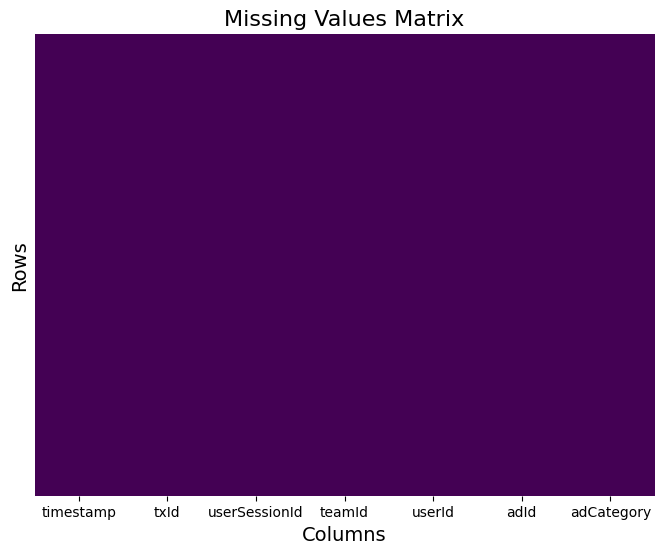

In [ ]:
show_missingno_matrix(data_frame = data_loaded["ad_clicks_pd"])

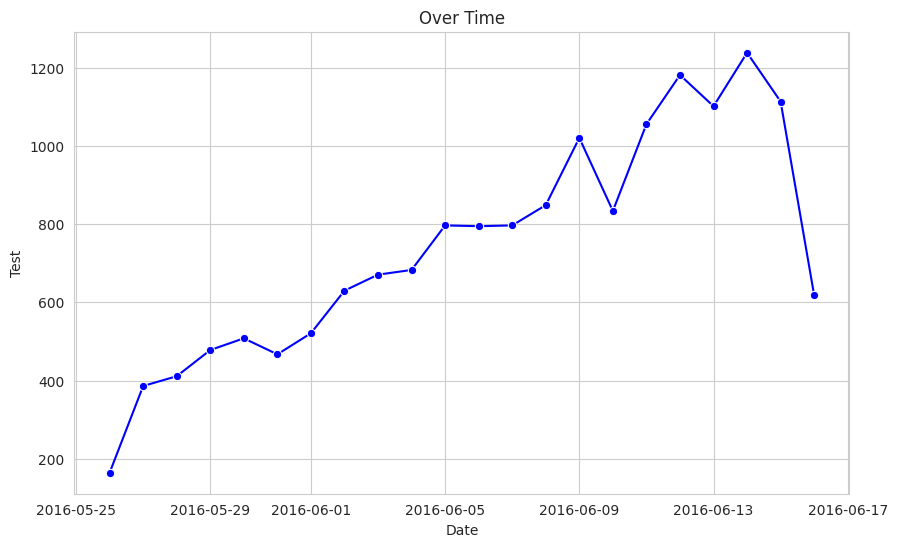

In [ ]:
generate_timeseries_plot(data_loaded["ad_clicks_pd"], timestamp_column='timestamp', xlabel='Date', ylabel='Test', title='Over Time', color='blue')

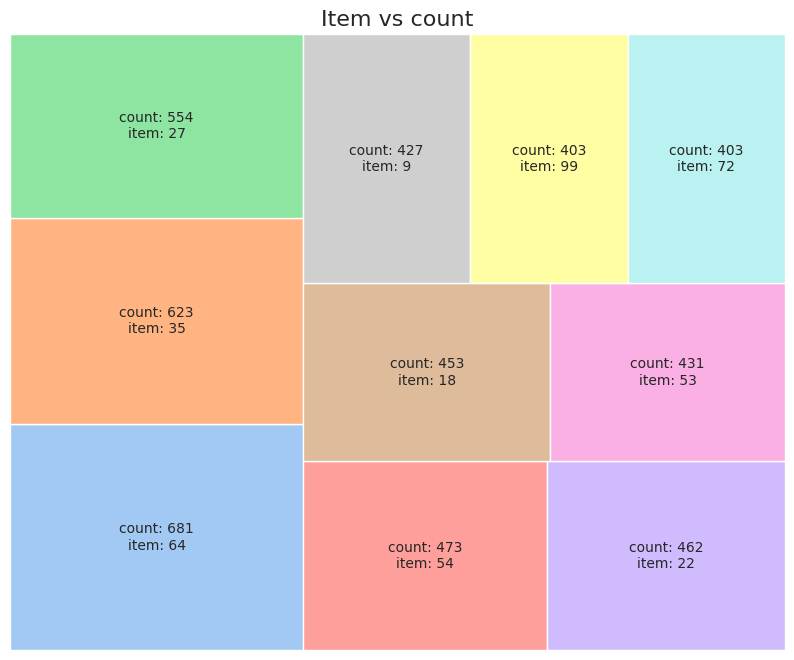

In [ ]:
generate_tree_map(count_occurrences(data_loaded["ad_clicks_pd"]["teamId"]).\
                  sort_values(by=['count'], ascending=False).head(10),
                  item_1 = "count",
                  item_2 = "item",
                  item_1_txt= "count",
                  item_2_txt= "item",
                  title = "Item vs count",
                  )

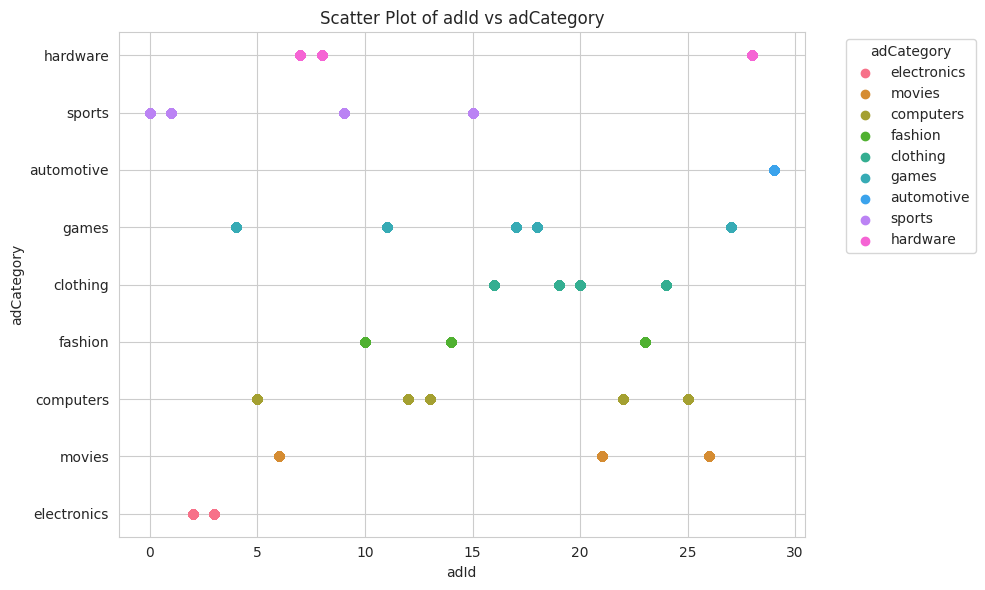

In [ ]:
create_ad_graph(data_frame = data_loaded["ad_clicks_pd"][["adId","adCategory"]])

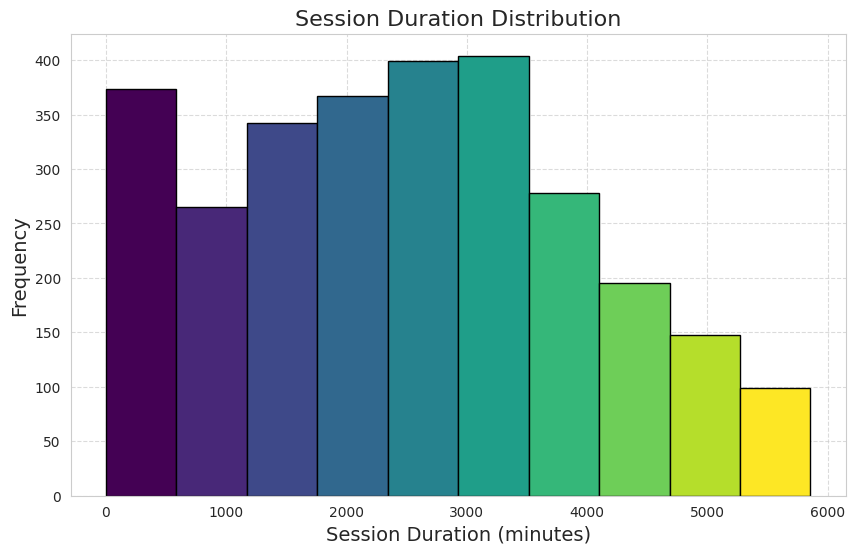

In [ ]:
# Convert 'timestamp' column to datetime objects
data_loaded["ad_clicks_pd"]["timestamp"] = pd.to_datetime(data_loaded["ad_clicks_pd"]["timestamp"])

# Calculate session duration
session_duration = data_loaded["ad_clicks_pd"].groupby('userSessionId')['timestamp'].apply(lambda x: (x.max() - x.min()).total_seconds() / 60)

# Define the number of bins
num_bins = 10

# Plotting the histogram with different colors for each bar
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(session_duration, bins=num_bins, edgecolor='black')

# Generate a list of distinct colors for each bar
colors = plt.cm.viridis(np.linspace(0, 1, len(patches)))

for patch, color in zip(patches, colors):
    patch.set_facecolor(color)

plt.xlabel('Session Duration (minutes)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Session Duration Distribution', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

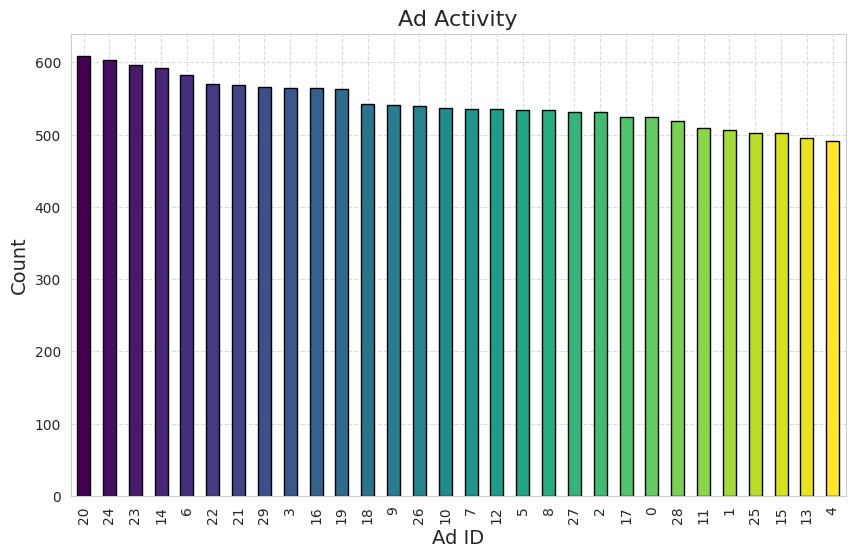

In [ ]:
# Count the occurrences of each ad ID
ad_counts = data_loaded["ad_clicks_pd"]['adId'].value_counts()

# Plotting the bar plot for ad activity with different colors for each bar
plt.figure(figsize=(10, 6))

# Generate a range of colors using a colormap
colors = plt.cm.viridis(np.linspace(0, 1, len(ad_counts)))

# Plotting each bar with a different color
ad_counts.plot(kind='bar', color=colors, edgecolor='black')

plt.xlabel('Ad ID', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Ad Activity', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

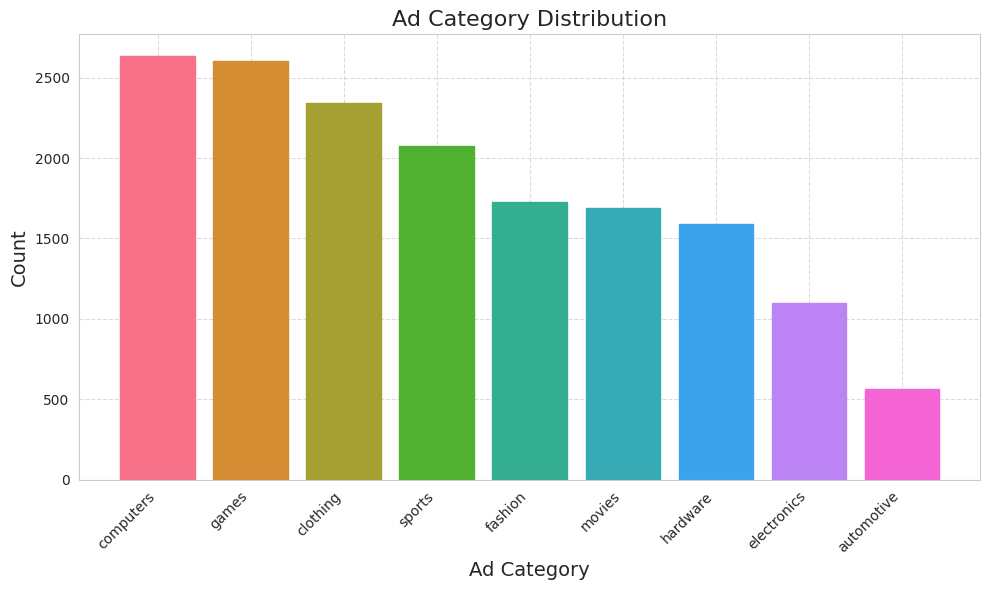

In [ ]:
# Count the occurrences of each ad category
category_counts = data_loaded["ad_clicks_pd"]['adCategory'].value_counts()

# Set a different color palette
colors = sns.color_palette("husl", len(category_counts))

# Plotting the bar plot for ad category distribution with different colors for each bar
plt.figure(figsize=(10, 6))
bars = plt.bar(category_counts.index, category_counts, edgecolor='black')

# Set different colors for each bar
for bar, color in zip(bars, colors):
    bar.set_color(color)

plt.xlabel('Ad Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Ad Category Distribution', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

### buy clicks

In [ ]:
data_loaded["buy_clicks_pd"].head()

,timestamp,txId,userSessionId,team,userId,buyId,price
0,2016-05-26 15:36:54,6004,5820,9,1300,2,3.0
1,2016-05-26 15:36:54,6005,5775,35,868,4,10.0
2,2016-05-26 15:36:54,6006,5679,97,819,5,20.0
3,2016-05-26 16:36:54,6067,5665,18,121,2,3.0
4,2016-05-26 17:06:54,6093,5709,11,2222,5,20.0


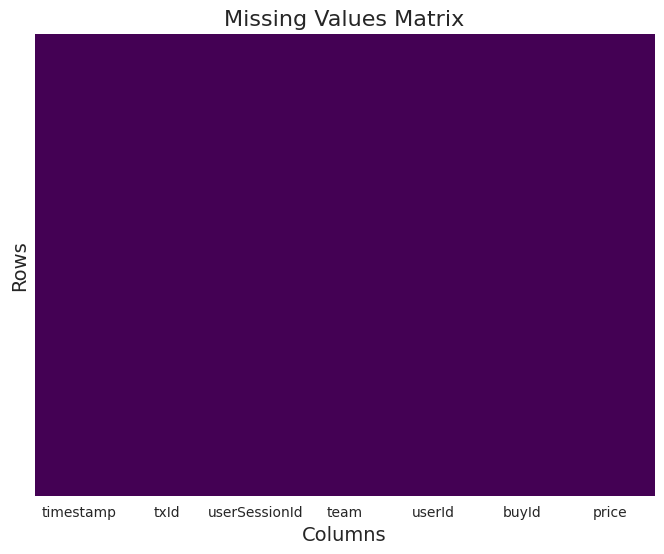

In [ ]:
show_missingno_matrix(data_frame = data_loaded["buy_clicks_pd"])

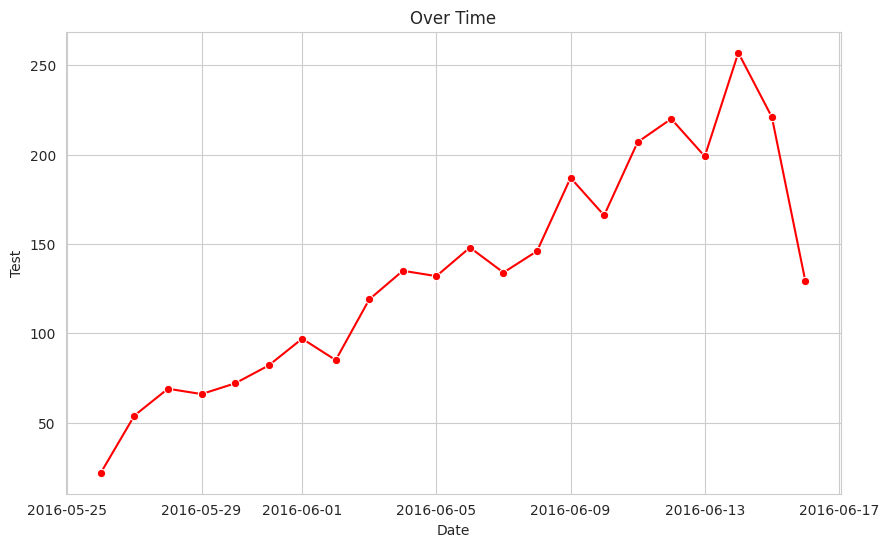

In [ ]:
generate_timeseries_plot(data_loaded["buy_clicks_pd"], timestamp_column='timestamp', xlabel='Date', ylabel='Test', title='Over Time', color='red')

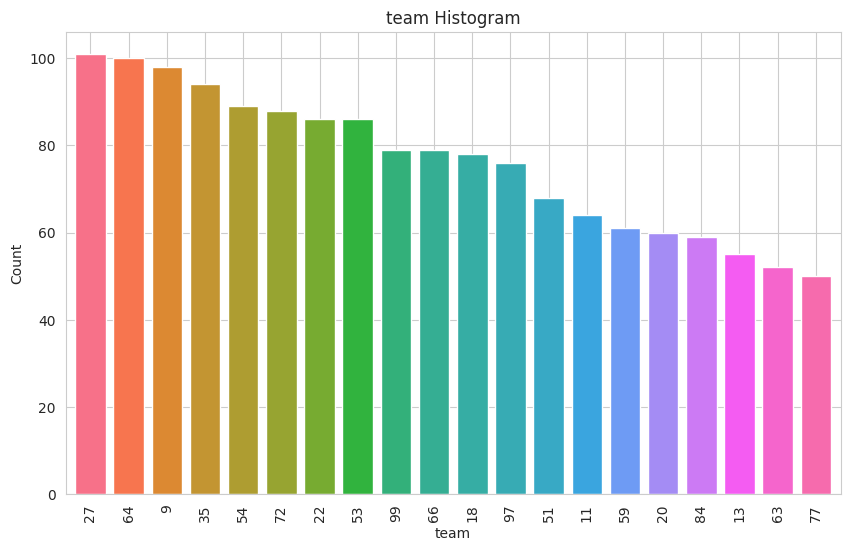

In [ ]:
create_histogram(column = data_loaded["buy_clicks_pd"]["team"],
                 num_show=20)

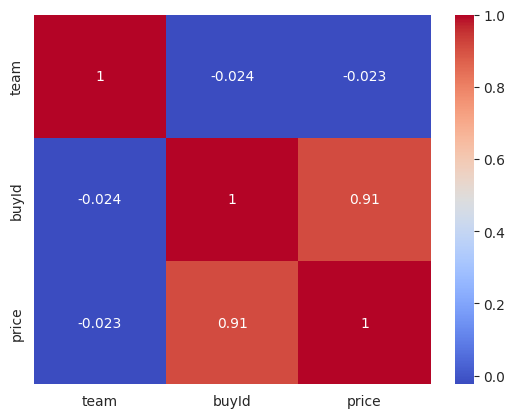

In [ ]:
create_correlation_plot(data_frame = data_loaded["buy_clicks_pd"][["team","buyId", "price"]])

### combined data

In [ ]:
data_loaded["combined_data_pd"].head()

,userId,userSessionId,teamLevel,platformType,count_gameclicks,count_hits,count_buyId,avg_price
0,812,5648,1,android,69,8,NaN,NaN
1,1658,5649,1,iphone,31,5,NaN,NaN
2,1589,5650,1,iphone,26,2,NaN,NaN
3,1863,5651,1,android,35,4,NaN,NaN
4,937,5652,1,android,39,0,1.0,1.0


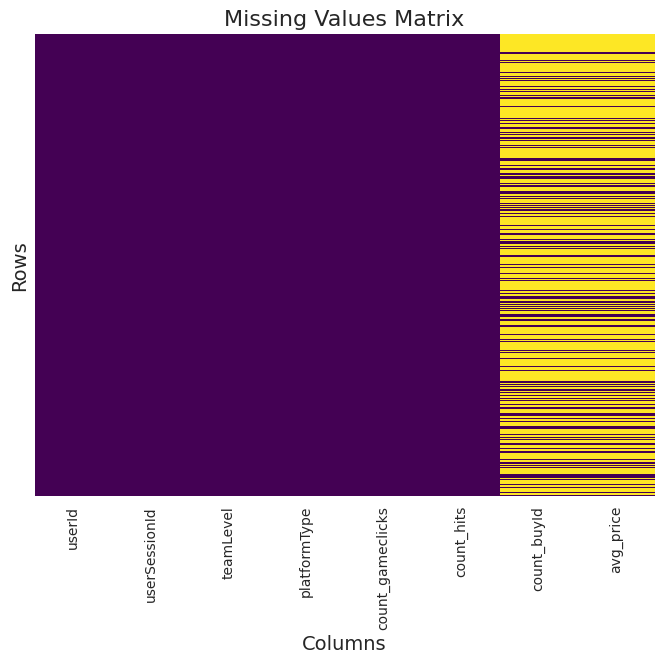

In [ ]:
show_missingno_matrix(data_frame = data_loaded["combined_data_pd"])

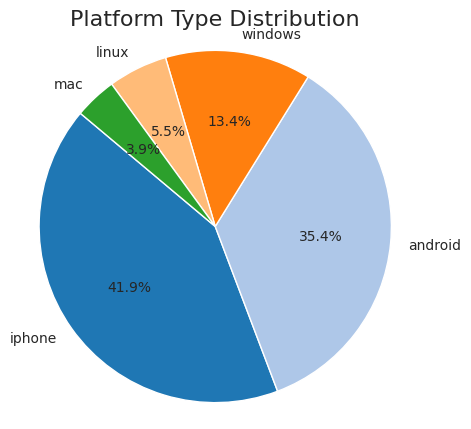

In [ ]:
# Count the occurrences of each platform type
platform_counts = data_loaded["combined_data_pd"]["platformType"].value_counts()

# Create a pie chart
plt.figure(figsize=(5,5))
plt.pie(platform_counts, labels=platform_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
plt.title('Platform Type Distribution', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

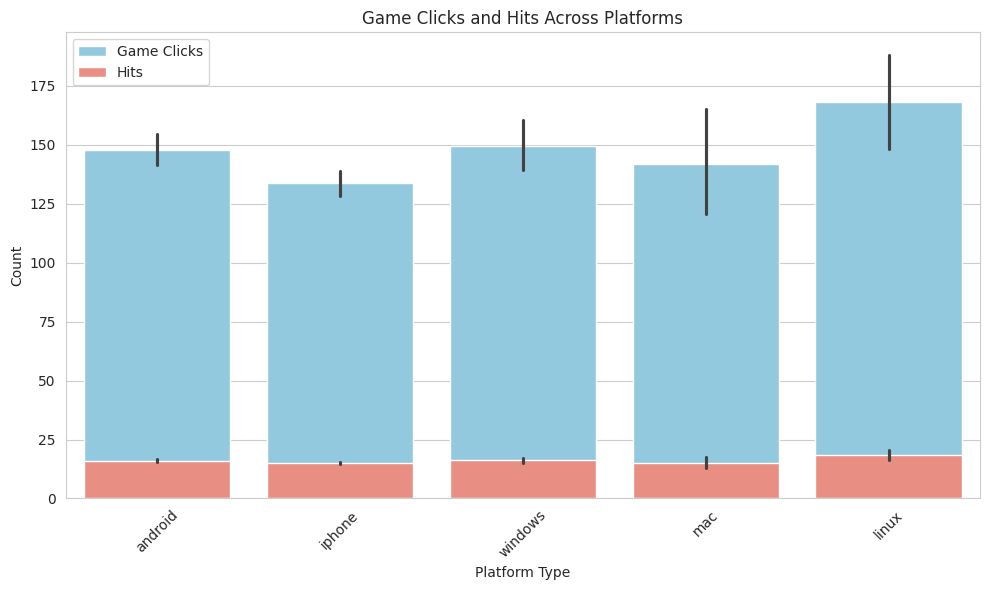

In [ ]:
def create_multi_graph(data_frame):
    # Set the style
    sns.set_style("whitegrid")

    # Create the multi-graph using bar plots
    plt.figure(figsize=(10, 6))
    sns.barplot(data=data_frame, x="platformType", y="count_gameclicks", color="skyblue", label="Game Clicks")
    sns.barplot(data=data_frame, x="platformType", y="count_hits", color="salmon", label="Hits")
    plt.title("Game Clicks and Hits Across Platforms")
    plt.xlabel("Platform Type")
    plt.ylabel("Count")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Assuming data_loaded["combined_data_pd"] is your DataFrame
create_multi_graph(data_loaded["combined_data_pd"][["platformType","count_gameclicks","count_hits"]])

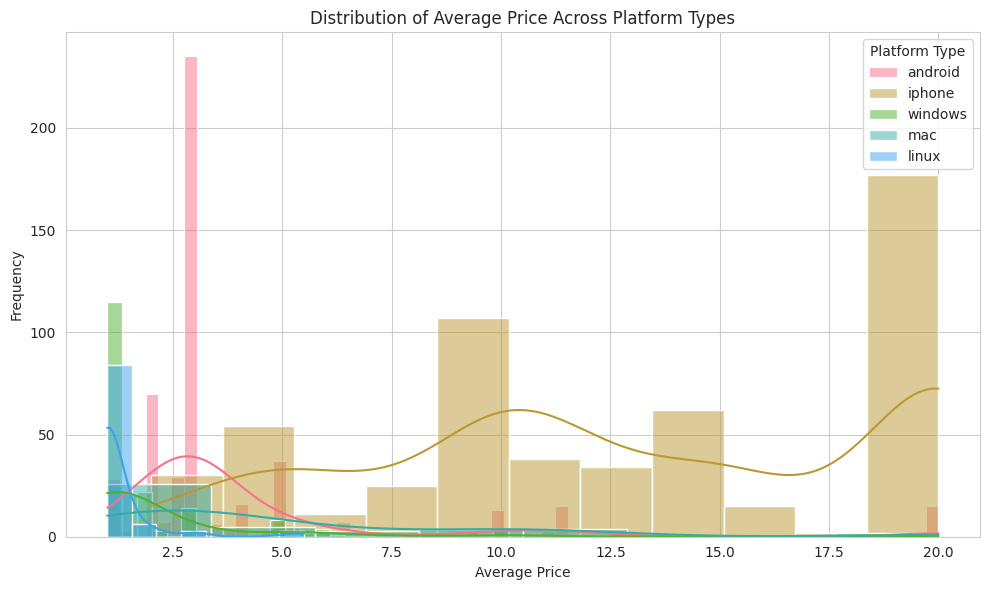

In [ ]:
def create_price_histogram(data_frame):
    # Set the style
    sns.set_style("whitegrid")

    # Create separate histograms for each platform type
    plt.figure(figsize=(10, 6))
    for platform_type in data_frame["platformType"].unique():
        sns.histplot(data=data_frame[data_frame["platformType"] == platform_type]["avg_price"], kde=True, label=platform_type, alpha=0.5)

    # Add title and labels
    plt.title("Distribution of Average Price Across Platform Types")
    plt.xlabel("Average Price")
    plt.ylabel("Frequency")

    # Add legend
    plt.legend(title="Platform Type")

    plt.tight_layout()
    plt.show()

# Assuming data_loaded["combined_data_pd"] is your DataFrame
data = data_loaded["combined_data_pd"]
if "platformType" in data.columns and "avg_price" in data.columns:
    create_price_histogram(data)
else:
    print("Required columns are missing in the DataFrame.")

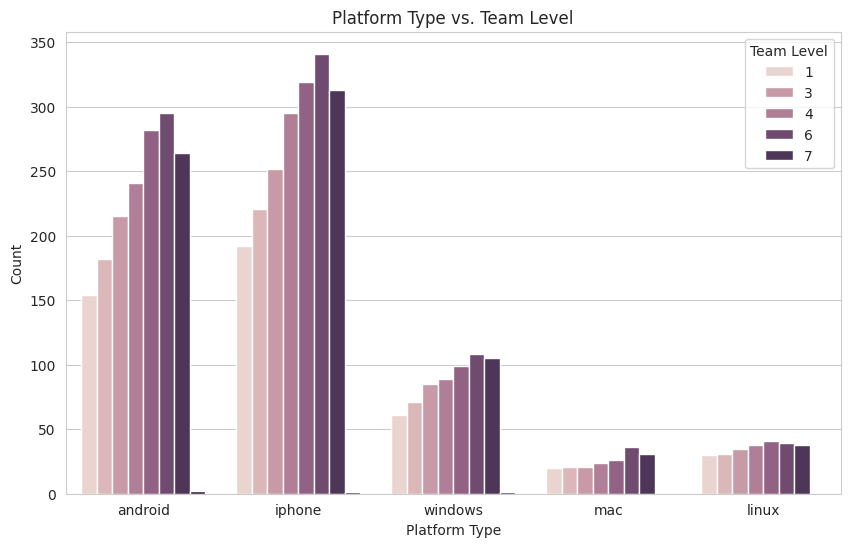

In [ ]:
# Load the data
combined_data = data_loaded["combined_data_pd"]

# 1. Platform Type vs. Team Level
plt.figure(figsize=(10, 6))
sns.countplot(x='platformType', hue='teamLevel', data=combined_data)
plt.title('Platform Type vs. Team Level')
plt.xlabel('Platform Type')
plt.ylabel('Count')
plt.legend(title='Team Level')
plt.show()

<ipython-input-53-a623bc234109>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='platformType', y='conversion_rate', data=platform_conversion_rate, palette=palette)
<ipython-input-53-a623bc234109>:6: UserWarning: The palette list has more values (8) than needed (5), which may not be intended.
  sns.barplot(x='platformType', y='conversion_rate', data=platform_conversion_rate, palette=palette)


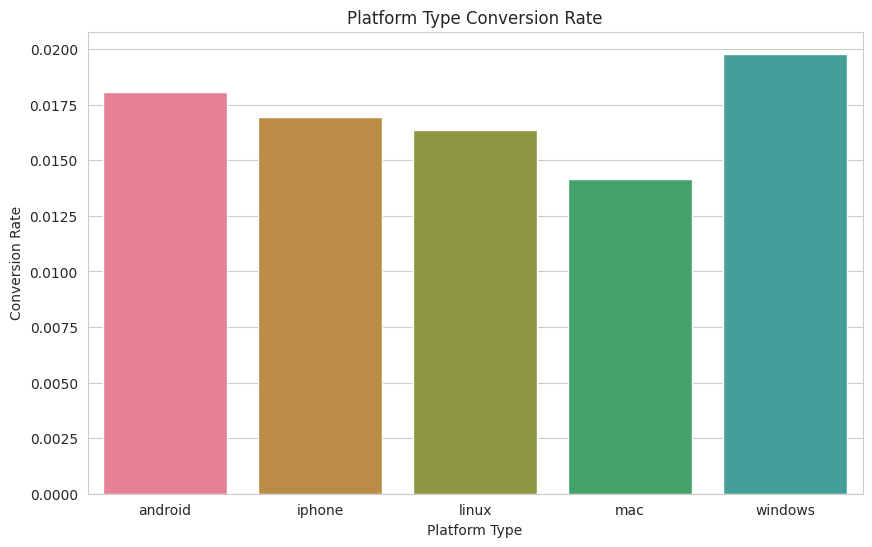

In [ ]:
# 3. Platform Type Conversion Rate
combined_data['conversion_rate'] = combined_data['count_buyId'] / combined_data['count_gameclicks']
platform_conversion_rate = combined_data.groupby('platformType')['conversion_rate'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='platformType', y='conversion_rate', data=platform_conversion_rate, palette=palette)
plt.title('Platform Type Conversion Rate')
plt.xlabel('Platform Type')
plt.ylabel('Conversion Rate')
plt.show()

### game clicks

In [ ]:
data_loaded["game_clicks_pd"].head()

,timestamp,clickId,userId,userSessionId,isHit,teamId,teamLevel
0,2016-05-26 15:06:55,105,1038,5916,0,25,1
1,2016-05-26 15:07:09,154,1099,5898,0,44,1
2,2016-05-26 15:07:14,229,899,5757,0,71,1
3,2016-05-26 15:07:14,322,2197,5854,0,99,1
4,2016-05-26 15:07:20,22,1362,5739,0,13,1


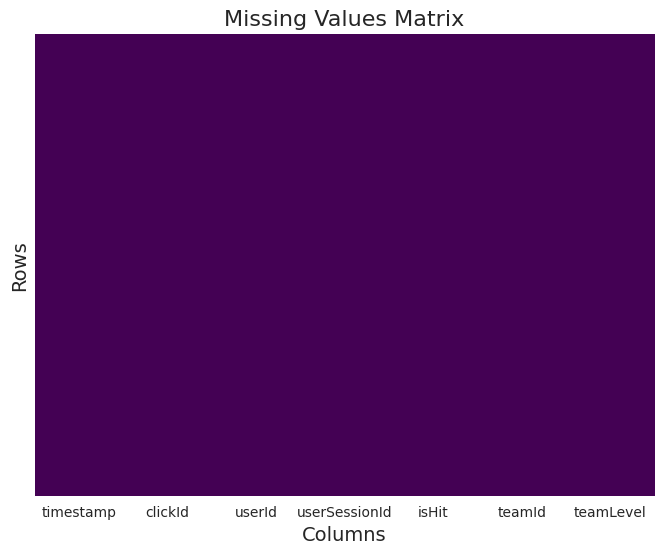

In [ ]:
show_missingno_matrix(data_frame = data_loaded["game_clicks_pd"])

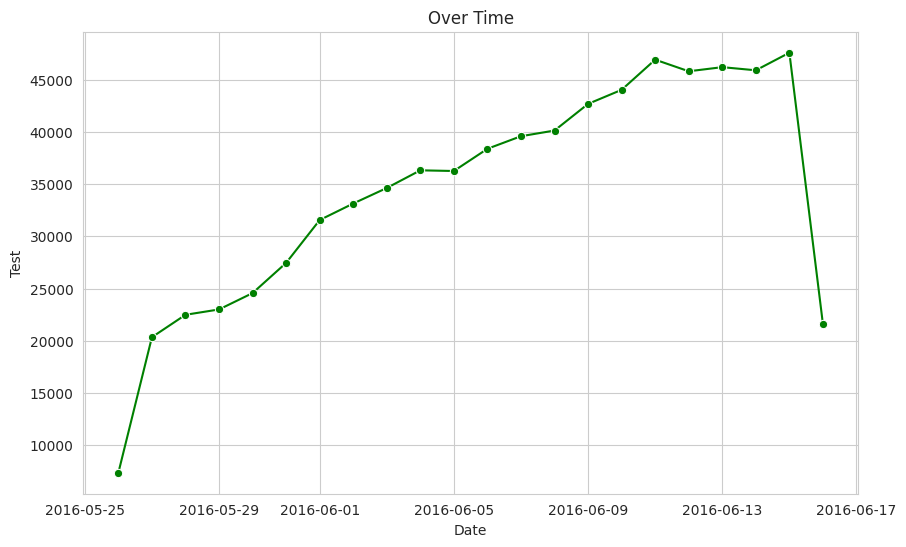

In [ ]:
generate_timeseries_plot(data_loaded["game_clicks_pd"], timestamp_column='timestamp', xlabel='Date', ylabel='Test', title='Over Time', color='green')

### level events

In [ ]:
data_loaded["level_events_pd"].head()

,timestamp,eventId,teamId,teamLevel,eventType
0,2016-05-27 23:06:54,0,2,1,end
1,2016-05-27 23:06:54,1,2,2,start
2,2016-05-27 23:06:54,2,8,1,end
3,2016-05-27 23:06:54,3,8,2,start
4,2016-05-27 23:06:54,4,9,1,end


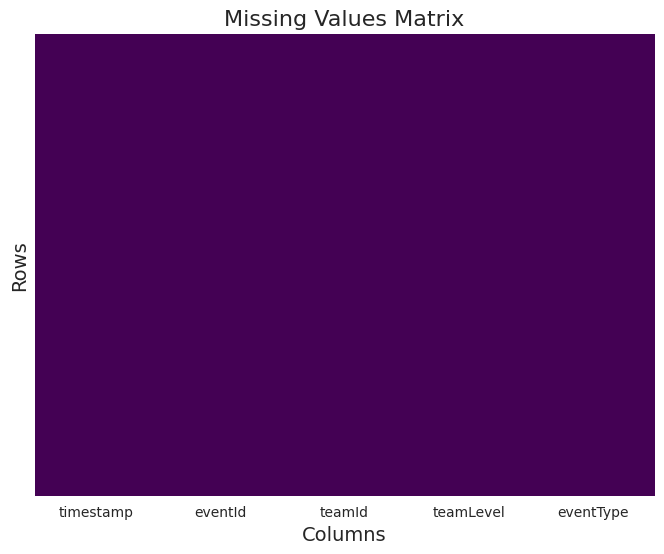

In [ ]:
show_missingno_matrix(data_frame = data_loaded["level_events_pd"])

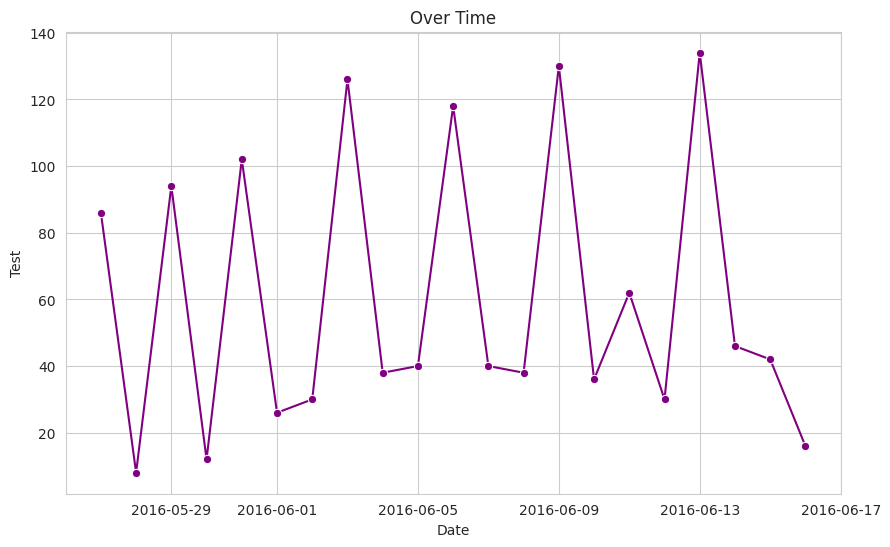

In [ ]:
generate_timeseries_plot(data_loaded["level_events_pd"], timestamp_column='timestamp', xlabel='Date', ylabel='Test', title='Over Time', color='purple')

### team assignments

In [ ]:
data_loaded["team_assignments_pd"].head()

,timestamp,team,userId,assignmentId
0,2016-05-26 14:06:54,64,504,5439
1,2016-05-26 14:07:00,39,1698,5301
2,2016-05-26 14:07:04,85,81,5540
3,2016-05-26 14:07:08,95,1976,5307
4,2016-05-26 14:07:09,97,1009,5368


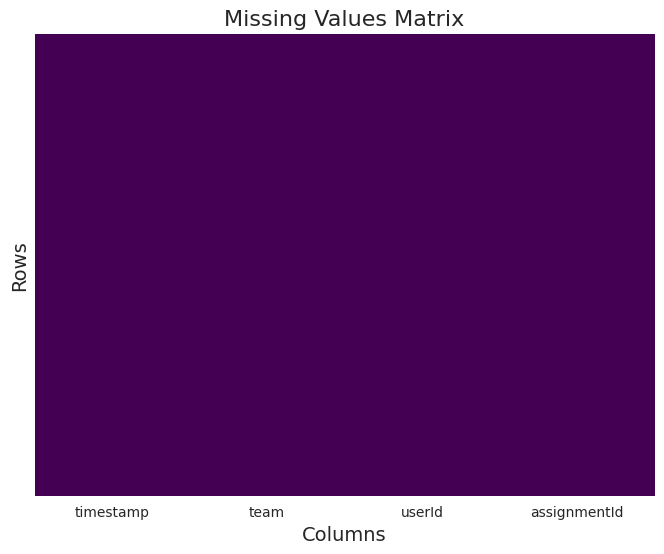

In [ ]:
show_missingno_matrix(data_frame = data_loaded["team_assignments_pd"])

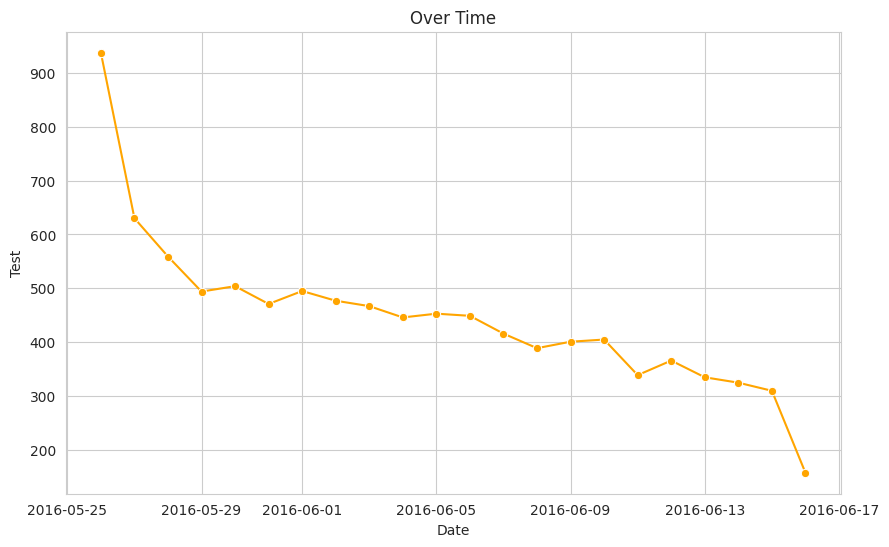

In [ ]:
generate_timeseries_plot(data_loaded["team_assignments_pd"], timestamp_column='timestamp', xlabel='Date', ylabel='Test', title='Over Time', color='orange')

### team

In [ ]:
data_loaded["team_pd"].head()

,teamId,name,teamEndTime,strength,currentLevel
teamCreationTime,,,,,
2016-06-12 15:33:27,79,O1uJX7C,9999-12-31 23:59:59,0.774474,1
2016-06-12 21:54:20,92,WeLHp8HZ,9999-12-31 23:59:59,0.171926,1
2016-06-12 23:02:16,6,mARlfz,9999-12-31 23:59:59,0.537353,1
2016-06-13 06:03:03,7,xO41jlAo0Y,9999-12-31 23:59:59,0.394370,1
2016-06-13 07:01:03,40,vdwO0k1,9999-12-31 23:59:59,0.706833,1


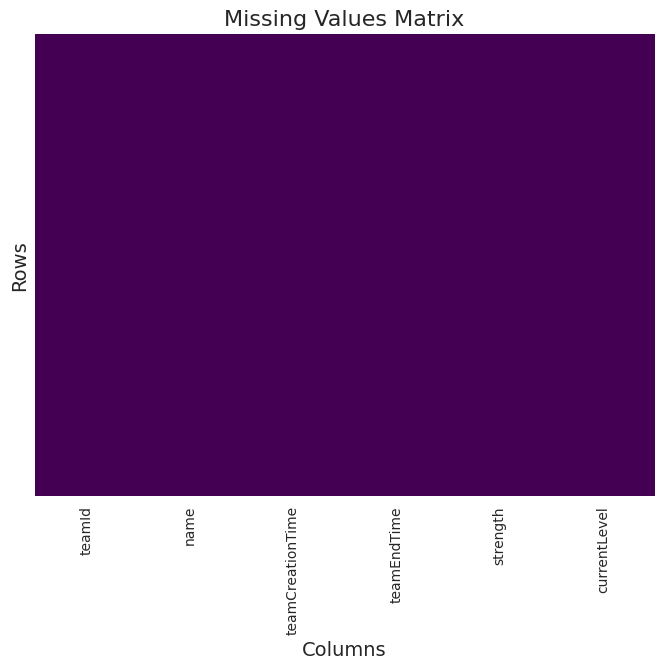

In [ ]:
show_missingno_matrix(data_frame = data_loaded["team_pd"])

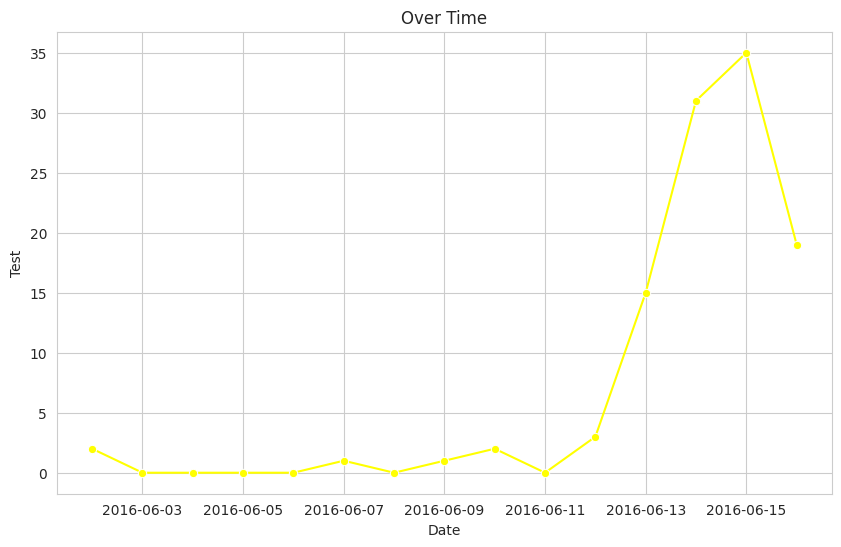

In [ ]:
generate_timeseries_plot(data_loaded["team_pd"], timestamp_column='teamCreationTime', xlabel='Date', ylabel='Test', title='Over Time', color='yellow')

<ipython-input-11-e62fd49fe320>:272: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data_frame.teamId.astype(str).values, rotation=45, ha='right', fontsize=10)


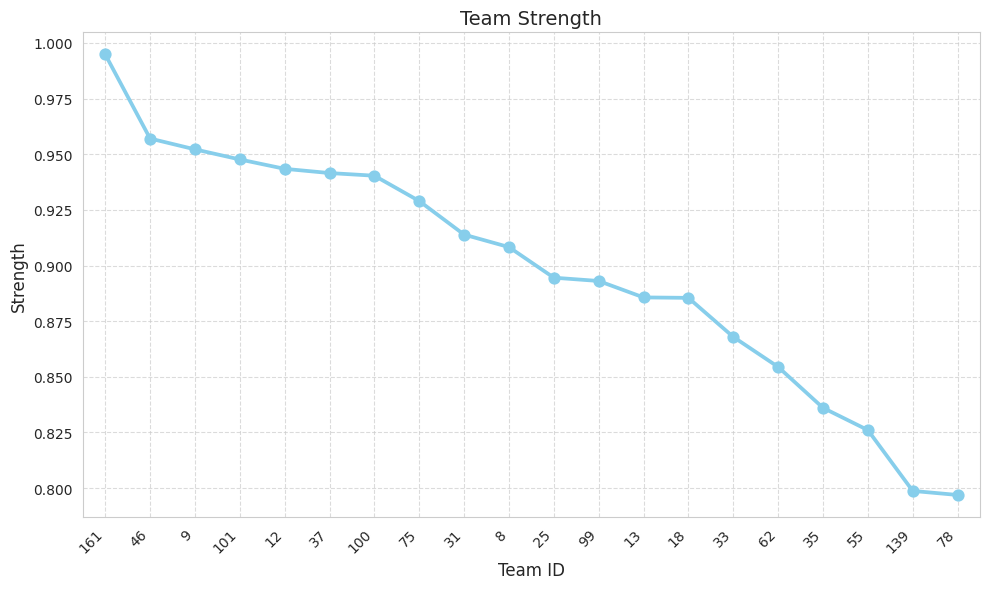

In [ ]:
create_team_strength(data_frame=data_loaded["team_pd"],
                     x_lab="Team ID",
                     y_lab="Strength")

<ipython-input-11-e62fd49fe320>:272: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data_frame.teamId.astype(str).values, rotation=45, ha='right', fontsize=10)


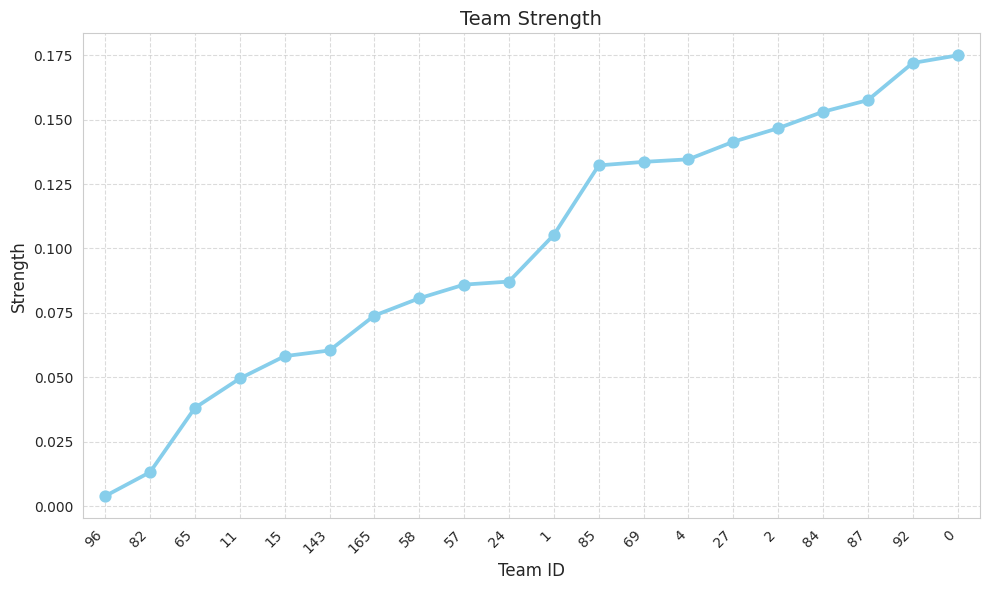

In [ ]:
create_team_strength(data_frame=data_loaded["team_pd"],
                     x_lab="Team ID",
                     y_lab="Strength",
                     asc = True)

### user session

In [ ]:
data_loaded["user_session_pd"].head()

,userSessionId,userId,teamId,assignmentId,sessionType,teamLevel,platformType
timestamp,,,,,,,
2016-05-26 14:47:30,5675,170,90,5423,start,1,iphone
2016-05-27 00:06:54,5675,170,90,5423,end,1,iphone
2016-05-26 14:43:09,5795,835,39,5300,start,1,android
2016-05-27 08:06:54,5795,835,39,5300,end,1,android
2016-05-26 14:47:20,5833,624,2,5529,start,1,iphone


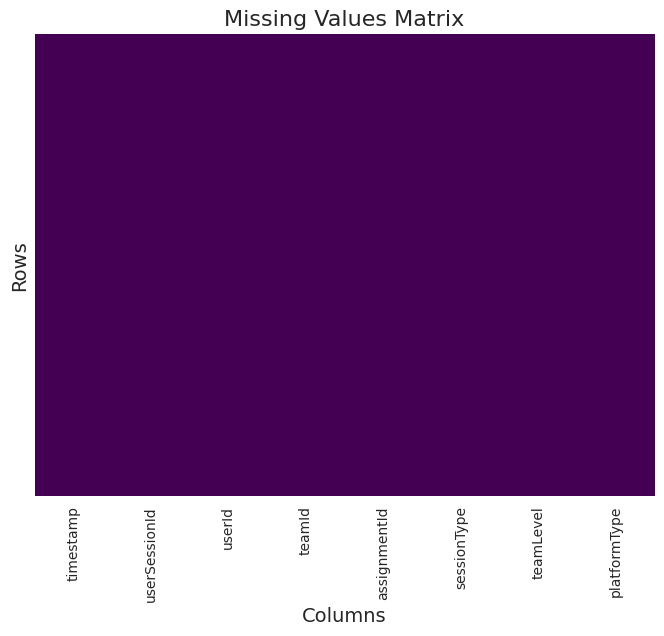

In [ ]:
show_missingno_matrix(data_frame = data_loaded["user_session_pd"])

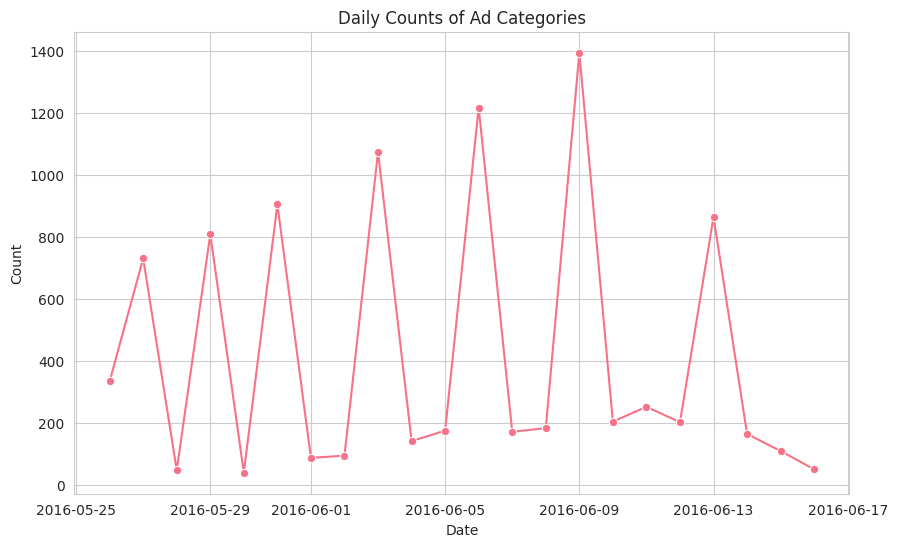

In [ ]:
generate_timeseries_plot(data_loaded["user_session_pd"], timestamp_column='timestamp')

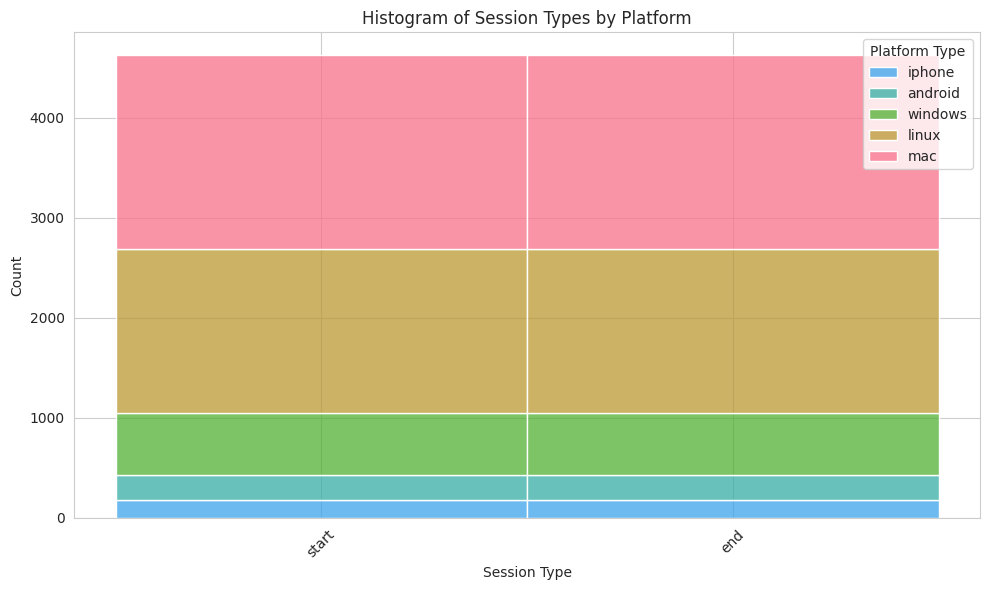

In [ ]:
def create_histogram_session(data_frame):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=data_frame, x='sessionType', hue='platformType', multiple='stack')
    plt.xlabel('Session Type')
    plt.ylabel('Count')
    plt.title('Histogram of Session Types by Platform')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.legend(title='Platform Type', labels=data_frame['platformType'].unique())  # Specify legend labels
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()

# Call the function with your DataFrame
create_histogram_session(data_loaded["user_session_pd"][["sessionType", "platformType"]])

### users

In [ ]:
data_loaded["users_pd"].head()

,timestamp,userId,nick,twitter,dob,country
0,2012-06-19 14:53:41,442,pcjIOBKW,@SZhyOHv,1994-07-20,BA
1,2012-06-19 19:29:01,949,vAOfUkf,@nkkNo,1971-04-22,HU
2,2012-06-20 19:34:59,1654,qOOXSQ,@SwOlw,1970-04-19,IS
3,2012-06-21 01:18:29,1586,px4gW51,@IrCHTnE,1965-11-23,AM
4,2012-06-21 15:35:00,599,9gkfwRC73Uc,@VJj0Az,1994-08-23,CC


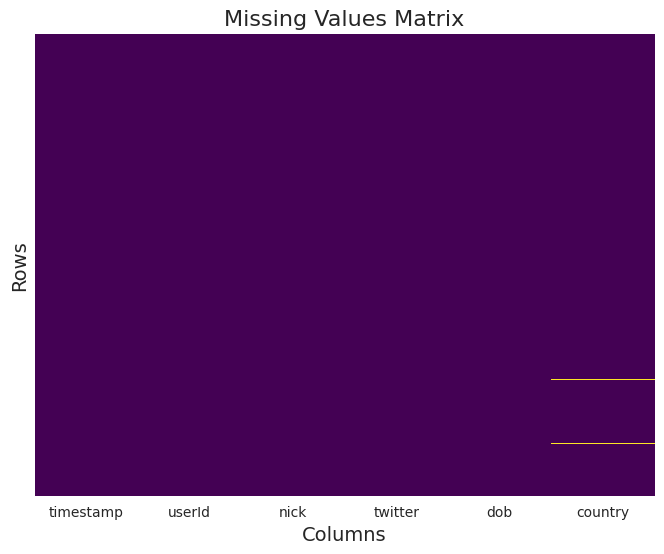

In [ ]:
show_missingno_matrix(data_frame = data_loaded["users_pd"])

<ipython-input-11-e62fd49fe320>:303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['dob'] = pd.to_datetime(data_frame['dob'])
<ipython-input-11-e62fd49fe320>:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['year'] = data_frame['dob'].dt.year


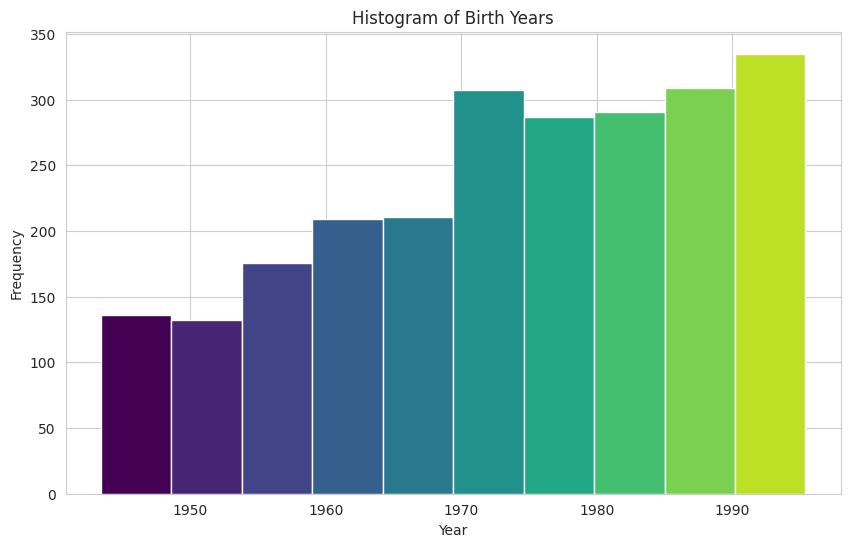

In [ ]:
create_dob_histogram(data_frame=data_loaded["users_pd"][["dob"]])

<ipython-input-93-2f63b00b0fe6>:12: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


Missing country codes: {'AL', 'AR', 'CH', 'MT', 'ID', 'BH', 'LS', 'AN', 'ZA', 'PM', 'MG', 'GW', 'VI', 'AD', 'CX', 'KE', 'DZ', 'PG', 'GE', 'NU', 'GN', 'RO', 'KM', 'VE', 'CZ', 'WS', 'BY', 'MC', 'BN', 'LR', 'US', 'KI', 'GM', 'NR', 'NL', 'BB', 'AO', 'AQ', 'GL', 'AW', 'PK', 'TK', 'SL', 'PF', 'MA', 'LY', 'MO', 'VC', 'CK', 'EG', 'CG', 'PS', 'TV', 'GT', 'TO', 'ME', 'TF', 'PL', 'RE', 'BW', 'KV', 'SM', 'AU', 'MM', 'IR', 'AZ', 'PH', 'NI', 'LT', 'VN', 'UY', 'SG', 'PN', 'PW', 'LB', 'KZ', 'TP', 'MU', 'BS', 'PA', 'MW', 'KP', 'PR', 'IS', 'AT', 'BI', 'EC', 'NZ', 'LU', 'ES', 'HR', 'CL', 'SA', 'KH', 'IQ', 'BF', 'WF', 'UM', 'DJ', 'RS', 'OM', 'SD', 'BZ', 'RW', 'KW', 'CN', 'MD', 'UG', 'BO', 'MS', 'MX', 'GH', 'TJ', 'YE', 'PY', 'PE', 'BR', 'LI', 'SH', 'VU', 'AE', 'ER', 'SV', 'KY', 'PT', 'NE', 'JO', 'GP', 'MZ', 'SC', 'RU', 'GA', 'BA', 'TH', 'NF', 'CA', 'ML', 'CO', 'GQ', 'TM', 'CU', 'IE', 'SR', 'ET', 'HM', 'EH', 'TZ', 'HT', 'GF', 'NG', 'VA', 'GI', 'SY', 'AF', 'BM', 'LA', 'LV', 'CY', 'BG', 'HU', 'BE', 'EE', 'GR'

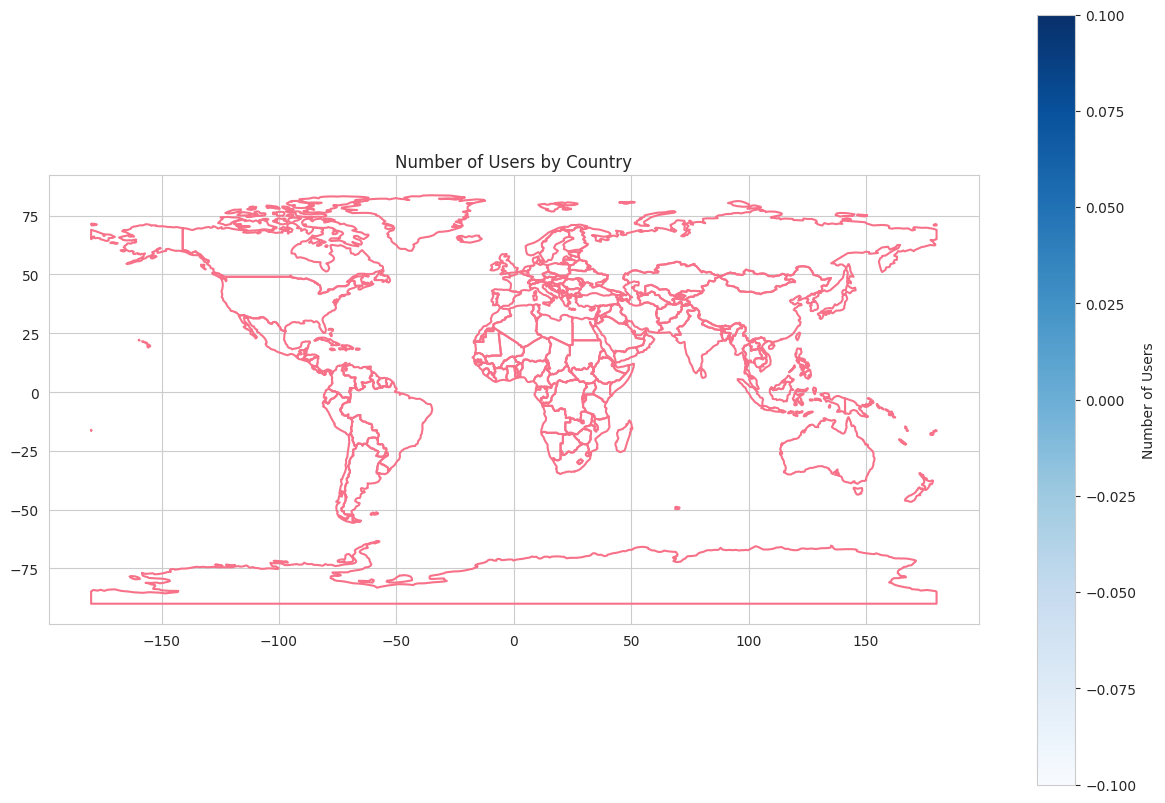

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming data_loaded["users_pd"] is your DataFrame containing the user data

# Count the number of users in each country
country_counts = data_loaded["users_pd"]['country'].value_counts().reset_index()
country_counts.columns = ['country', 'user_count']

# Load world shapefile for plotting
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Check for missing or mismatched values in country codes
missing_countries = set(country_counts['country']) - set(world['iso_a3'])
if missing_countries:
    print("Missing country codes:", missing_countries)

# Merge country counts with world data
world = world.merge(country_counts, how='left', left_on='iso_a3', right_on='country')

# Plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax)  # Plot world boundaries
world.plot(column='user_count', ax=ax, legend=True, legend_kwds={'label': 'Number of Users'}, cmap='Blues')
ax.set_title('Number of Users by Country')
plt.show()


## **Data schema formation**

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType

schema_dict = {
     "chat-join-team-chat" : [
        StructField("user_id", IntegerType(), True),\
        StructField("teamchat_session_id", IntegerType(), True),\
        StructField("date", IntegerType(), True)
    ],
    "chat-leave-team-chat" : [
        StructField("user_id", IntegerType(), True),\
        StructField("teamchat_session_id", IntegerType(), True),\
        StructField("date", IntegerType(), True)
    ],
    "chat-mention-team-chat" : [
        StructField("chat_item", IntegerType(), True),\
        StructField("user_id", IntegerType(), True),\
        StructField("date", IntegerType(), True)
    ],
    "chat-respond-team-chat" : [
        StructField("chatid1", IntegerType(), True),\
        StructField("chatid2", IntegerType(), True),\
        StructField("date", IntegerType(), True)
    ],
    "ad-clicks": [
        StructField("timestamp", StringType(), True),
        StructField("txId", IntegerType(), True),
        StructField("userSessionId", IntegerType(), True),
        StructField("teamId", IntegerType(), True),
        StructField("userId", IntegerType(), True),
        StructField("adId", IntegerType(), True),
        StructField("adCategory", StringType(), True)
    ],
    "buy-clicks": [
        StructField("timestamp", StringType(), True),
        StructField("txId", IntegerType(), True),
        StructField("userSessionId", IntegerType(), True),
        StructField("team", IntegerType(), True),
        StructField("userId", IntegerType(), True),
        StructField("buyId", IntegerType(), True),
        StructField("price", DoubleType(), True)
    ],
    "game-clicks": [
        StructField("timestamp", StringType(), True),
        StructField("clickId", IntegerType(), True),
        StructField("userId", IntegerType(), True),
        StructField("userSessionId", IntegerType(), True),
        StructField("isHit", IntegerType(), True),
        StructField("teamId", IntegerType(), True),
        StructField("teamLevel", IntegerType(), True)
    ],
    "level-events": [
        StructField("timestamp", StringType(), True),
        StructField("eventId", IntegerType(), True),
        StructField("teamId", IntegerType(), True),
        StructField("teamLevel", IntegerType(), True),
        StructField("eventType", StringType(), True)
    ],
    "team-assignments": [
        StructField("timestamp", StringType(), True),
        StructField("team", IntegerType(), True),
        StructField("userId", IntegerType(), True),
        StructField("assignmentId", IntegerType(), True)
    ],
    "team": [
        StructField("teamId", IntegerType(), True),
        StructField("name", StringType(), True),
        StructField("teamCreationTime", StringType(), True),
        StructField("teamEndTime", StringType(), True),
        StructField("strength", DoubleType(), True),
        StructField("currentLevel", IntegerType(), True)
    ],
    "user-session": [
        StructField("timestamp", StringType(), True),
        StructField("userSessionId", IntegerType(), True),
        StructField("userId", IntegerType(), True),
        StructField("teamId", IntegerType(), True),
        StructField("assignmentId", IntegerType(), True),
        StructField("sessionType", StringType(), True),
        StructField("teamLevel", IntegerType(), True),
        StructField("platformType", StringType(), True)
    ],
    "users": [
        StructField("timestamp", StringType(), True),
        StructField("userId", IntegerType(), True),
        StructField("nick", StringType(), True),
        StructField("twitter", StringType(), True),
        StructField("dob", StringType(), True),
        StructField("country", StringType(), True)
    ],
    "combined-data": [
        StructField("userId", IntegerType(), True),
        StructField("userSessionId", IntegerType(), True),
        StructField("teamLevel", IntegerType(), True),
        StructField("platformType", StringType(), True),
        StructField("count_gameclicks", IntegerType(), True),
        StructField("count_hits", IntegerType(), True),
        StructField("count_buyId", DoubleType(), True),
        StructField("avg_price", DoubleType(), True)
    ]
}


## **Data Loading**

In [ ]:
data_chat_join_team_chat = spark.createDataFrame(
                              data_loaded["chat_join_team_chat_pd"],
                              schema=StructType(schema_dict["chat-join-team-chat"])
                              )

data_chat_leave_team_chat = spark.createDataFrame(
                              data_loaded["chat_leave_team_chat_pd"],
                              schema=StructType(schema_dict["chat-leave-team-chat"])
                              )

data_chat_mention_team_chat = spark.createDataFrame(
                              data_loaded["chat_mention_team_chat_pd"],
                              schema=StructType(schema_dict["chat-mention-team-chat"])
                              )

data_chat_respond_team_chat = spark.createDataFrame(
                              data_loaded["chat_respond_team_chat_pd"],
                              schema=StructType(schema_dict["chat-respond-team-chat"])
                              )
data_ad_clicks = spark.createDataFrame(
                              data_loaded["ad_clicks_pd"],
                              schema=StructType(schema_dict["ad-clicks"])
                              )

data_buy_clicks = spark.createDataFrame(
                              data_loaded["buy_clicks_pd"],
                              schema=StructType(schema_dict["buy-clicks"])
                              )

data_game_clicks = spark.createDataFrame(
                              data_loaded["game_clicks_pd"],
                              schema=StructType(schema_dict["game-clicks"])
                              )

data_level_events = spark.createDataFrame(
                              data_loaded["level_events_pd"],
                              schema=StructType(schema_dict["level-events"])
                              )

data_team_assignments = spark.createDataFrame(
                              data_loaded["team_assignments_pd"],
                              schema=StructType(schema_dict["team-assignments"])
                              )

data_team = spark.createDataFrame(
                              data_loaded["team_pd"],
                              schema=StructType(schema_dict["team"])
                              )

data_user_session = spark.createDataFrame(
                              data_loaded["user_session_pd"],
                              schema=StructType(schema_dict["user-session"])
                              )

data_users = spark.createDataFrame(
                              data_loaded["users_pd"],
                              schema=StructType(schema_dict["users"])
                              )

data_combined_data = spark.createDataFrame(
                              data_loaded["combined_data_pd"],
                              schema=StructType(schema_dict["combined-data"])
                              )


## **Data Transformation**

In [ ]:
def replace_value(df, column, to_replace, replace_with):
  return df.withColumn(column, regexp_replace(col(column), to_replace, replace_with))

def change_datatype(df, column, data_type):
  return df.withColumn(column, col(column).cast(data_type))

In [ ]:
data_combined_data = replace_value(data_combined_data, "count_buyId", "NaN", "null")
data_combined_data = change_datatype(data_combined_data, "count_buyId", "double")

data_combined_data = replace_value(data_combined_data, "avg_price", "NaN", "null")
data_combined_data = change_datatype(data_combined_data, "avg_price", "double")

data_game_clicks = replace_value(data_game_clicks, "isHit", "0", "False")
data_game_clicks = replace_value(data_game_clicks, "isHit", "1", "True")
data_game_clicks = change_datatype(data_game_clicks, "isHit", "boolean")

## **Join dataframes**

## **Mega frame**

In [ ]:
mega_dataframe = data_users.select("userId","nick","twitter", from_unixtime("dob", "yyyy-MM-dd").alias("dob"),"country")\
                .join(data_user_session.select("userId","teamId","platformType"), ["userId"], 'right')\
                .join(data_team.select("teamId","name","strength"), ["teamId"], 'left')\
                .join(data_ad_clicks.select("userId","adId","adCategory"), ["userId"], 'full')\
                .dropDuplicates()\
                .fillna({"strength":0})

mega_dataframe = mega_dataframe.select( *[ F.when(F.col(column).isNull(),'').otherwise(F.col(column)).alias(column) for column in mega_dataframe.columns])
mega_dataframe.show()

+------+------+-----------+----------+---+-------+------------+-----------+---------------+----+-----------+
|userId|teamId|       nick|   twitter|dob|country|platformType|       name|       strength|adId| adCategory|
+------+------+-----------+----------+---+-------+------------+-----------+---------------+----+-----------+
|   212|    63| CotUq3zaL2|  @9tQvp0F|   |     TF|     android|    eJWo4Fd| 0.659738471721|  22|  computers|
|   256|   137|    oSxHWjI|@rXBuUTylW|   |     FO|     android|           |            0.0|   2|electronics|
|   271|    13|  J2rOP4ad5| @lsmHn3rX|   |     CN|     android|   cz8t6Wli| 0.885665267397|  14|    fashion|
|   277|    99|    1MOGAKD|@hdDh6QD6b|   |     NO|      iphone|   0G8HvkLE| 0.893053922676|  27|      games|
|   412|    97|QHt1qaaKwvb|  @PRGJjmi|   |     RU|      iphone|     LjcMqQ| 0.340788463107|  12|  computers|
|   436|    95|jk05zIMmsmz| @uYSz9isY|   |     AO|     android|     5izIUy| 0.701621474289|  27|      games|
|   450|    27|   M

## **Ads frame**

In [ ]:
ad_dataframe = data_ad_clicks.select("teamId","userId","adId","adCategory")\
                .join(data_buy_clicks.select("team","userId","price"), ["userId"], 'full')\
                .join(data_users.select("userId","country"), ["userId"], 'full')\
                .dropDuplicates()\
                .fillna({
                         "teamId":0,
                         "adId":999,
                         "team":999,
                         "price":0
                         })

ad_dataframe = ad_dataframe.select( *[ F.when(F.col(column).isNull(),'').otherwise(F.col(column)).alias(column) for column in ad_dataframe.columns])
#ad_dataframe.show()

## **Check nulls in columns**

In [ ]:
sc = SparkContext.getOrCreate()
sql = SQLContext(sc)

def calc_null_percent(spark_df,sort=True):
    pd_col_count = spark_df.select([F.count(F.col(c)).alias(c)
                                        for (c,c_type) in spark_df.dtypes]
                                  ).toPandas().T.reset_index().rename(columns={0: 'total_count'
                                                                               ,'index':'column'})

    pd_col_null_count = spark_df.select([F.sum(F.when(F.isnan(c) | F.isnull(c),1).otherwise(0)).alias(c)
                                         for (c,c_type) in spark_df.dtypes]
                                       ).toPandas().T.reset_index().rename(columns={0: 'null_count'
                                                                                    ,'index':'column'})

    final_df = pd.merge(pd_col_count,pd_col_null_count,on=['column'])

    final_df['null_percentage'] = final_df['null_count'] * 100 / final_df['total_count']

    if len(final_df) == 0:
        print("There are no any missing values!")
        return None

    return final_df

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
nullStatsDF = sql.createDataFrame(calc_null_percent(mega_dataframe))

nullStatsDF.show()

nullStatsDF = sql.createDataFrame(calc_null_percent(ad_dataframe))

nullStatsDF.show()

+------------+-----------+----------+-------------------+
|      column|total_count|null_count|    null_percentage|
+------------+-----------+----------+-------------------+
|      userId|      10411|         0|                0.0|
|      teamId|      10411|         0|                0.0|
|        nick|      10411|         0|                0.0|
|     twitter|      10411|         0|                0.0|
|         dob|      10411|         0|                0.0|
|     country|      10411|        50|0.48026126212659687|
|platformType|      10411|         0|                0.0|
|        name|      10411|         0|                0.0|
|    strength|      10411|         0|                0.0|
|        adId|      10411|         0|                0.0|
|  adCategory|      10411|         0|                0.0|
+------------+-----------+----------+-------------------+

+----------+-----------+----------+-----------------+
|    column|total_count|null_count|  null_percentage|
+----------+---------

## **Machine Learning Models**

## **Classification**

In [ ]:
def split_data(data_frame):
    indexer = StringIndexer(inputCol="platformType", outputCol="label")
    data_frame = indexer.fit(data_frame).transform(data_frame)

    split_ratio = [0.8, 0.2]
    seed = 42
    train_data, test_data = data_frame.randomSplit(split_ratio, seed=seed)

    x_train = train_data.select("platformType").toPandas()
    y_train = train_data.select("label").toPandas()

    x_test = test_data.select("platformType").toPandas()
    y_test = test_data.select("label").toPandas()

    return x_train, x_test, y_train, y_test

def build_decision_tree_model(x_train, y_train):
    train_data = spark.createDataFrame(pd.concat([x_train, y_train], axis=1))

    platform_indexer = StringIndexer(inputCol="platformType", outputCol="platformIndex")
    train_data = platform_indexer.fit(train_data).transform(train_data)

    assembler = VectorAssembler(inputCols=["platformIndex"], outputCol="features")
    train_data = assembler.transform(train_data)

    dt = DecisionTreeClassifier(featuresCol="features", labelCol="label")

    # Create a parameter grid for hyperparameter tuning
    paramGrid = ParamGridBuilder() \
        .addGrid(dt.maxDepth, [2, 4, 6]) \
        .addGrid(dt.minInstancesPerNode, [1, 2, 4]) \
        .build()

    # Create cross-validator
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    crossval = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

    # Fit the model with cross-validation
    cvModel = crossval.fit(train_data)

    return cvModel.bestModel

def build_svm_model(x_train, y_train):
    train_data = spark.createDataFrame(pd.concat([x_train, y_train], axis=1))

    platform_indexer = StringIndexer(inputCol="platformType", outputCol="indexedLabel")
    train_data = platform_indexer.fit(train_data).transform(train_data)

    assembler = VectorAssembler(inputCols=["indexedLabel"], outputCol="features")
    train_data = assembler.transform(train_data)

    svm = LinearSVC(featuresCol="features", labelCol="indexedLabel")

    # Create a parameter grid for hyperparameter tuning
    paramGrid = ParamGridBuilder() \
        .addGrid(svm.maxIter, [10, 100]) \
        .addGrid(svm.regParam, [0.1, 0.01]) \
        .build()

    # Create OneVsRest classifier
    ovr = OneVsRest(classifier=svm)

    # Create cross-validator
    evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
    crossval = CrossValidator(estimator=ovr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

    # Fit the model with cross-validation
    cvModel = crossval.fit(train_data)

    return cvModel.bestModel

def evaluate_model(model, x_test, y_test, file_Path):
    test_data = spark.createDataFrame(pd.concat([x_test, y_test], axis=1))

    platform_indexer = StringIndexer(inputCol="platformType", outputCol="platformIndex")
    test_data = platform_indexer.fit(test_data).transform(test_data)

    assembler = VectorAssembler(inputCols=["platformIndex"], outputCol="features")
    test_data = assembler.transform(test_data)

    predictions = model.transform(test_data)

    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

    # Calculate metrics for each class
    class_labels = test_data.select("label").distinct().rdd.flatMap(lambda x: x).collect()
    metrics = {}

    for label in class_labels:
        evaluator.setMetricName("accuracy")
        evaluator.setMetricLabel(label)
        accuracy = evaluator.evaluate(predictions)

        evaluator.setMetricName("weightedPrecision")
        evaluator.setMetricLabel(label)
        precision = evaluator.evaluate(predictions)

        evaluator.setMetricName("weightedRecall")
        evaluator.setMetricLabel(label)
        recall = evaluator.evaluate(predictions)

        evaluator.setMetricName("weightedFMeasure")
        evaluator.setMetricLabel(label)
        f1_score = evaluator.evaluate(predictions)

        metrics[label] = {"accuracy": accuracy, "precision": precision, "recall": recall, "f1-score": f1_score}

    predictionAndLabels = predictions.select("prediction", "label").rdd
    multiclass_metrics = MulticlassMetrics(predictionAndLabels)
    confusion_matrix = multiclass_metrics.confusionMatrix().toArray()

    label_counts = predictionAndLabels.map(lambda x: (x[1], 1)).reduceByKey(lambda x, y: x + y).collectAsMap()
    support = {label: label_counts.get(label, 0) for label in class_labels}

    # Print Metrics per Class as a Table
    metrics_table = pd.DataFrame.from_dict(metrics, orient="index")
    print("Metrics per Class:")
    print(metrics_table)

    # Print Support as a Table
    support_table = pd.DataFrame.from_dict(support, orient="index", columns=["Support"])
    print("Support:")
    print(support_table)

    # Plot Confusion Matrix
    fig, ax = plt.subplots()
    im = ax.imshow(confusion_matrix, cmap="Blues")

    # Create tick labels
    tick_labels = np.arange(len(class_labels))
    ax.set_xticks(tick_labels)
    ax.set_yticks(tick_labels)
    ax.set_xticklabels(class_labels, rotation=45)
    ax.set_yticklabels(class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Count", rotation=-90, va="bottom")

    # Add value annotations
    for i in range(len(class_labels)):
        for j in range(len(class_labels)):
            text = ax.text(j, i, int(confusion_matrix[i, j]), ha="center", va="center", color="w")

    plt.title("Confusion Matrix")

    # Save the metrics and confusion matrix plots to the specified file path
    metrics_table.to_csv(file_Path + "/metrics.csv")
    plt.savefig(file_Path + "/confusion_matrix.png")

    # Close the figure to free up resources
    plt.close()

In [ ]:
x_train, x_test, y_train, y_test = split_data(mega_dataframe)

In [ ]:
dt_model = build_decision_tree_model(x_train, y_train)

In [ ]:
evaluate_model(dt_model, x_test, y_test, file_Path = file_paths_dict["classification_dt"])

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Metrics per Class:
     accuracy  precision  recall  f1-score
0.0       1.0        1.0     1.0       1.0
1.0       1.0        1.0     1.0       1.0
4.0       1.0        1.0     1.0       1.0
3.0       1.0        1.0     1.0       1.0
2.0       1.0        1.0     1.0       1.0
5.0       1.0        1.0     1.0       1.0
Support:
     Support
0.0      830
1.0      696
4.0       62
3.0      122
2.0      264
5.0       34


In [ ]:
svm_model = build_svm_model(x_train, y_train)

In [ ]:
evaluate_model(svm_model, x_test, y_test, file_Path = file_paths_dict["classification_svm"])

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Metrics per Class:
     accuracy  precision    recall  f1-score
0.0  0.575697   0.465366  0.575697  0.489153
1.0  0.575697   0.465366  0.575697  0.489153
4.0  0.575697   0.465366  0.575697  0.489153
3.0  0.575697   0.465366  0.575697  0.489153
2.0  0.575697   0.465366  0.575697  0.489153
5.0  0.575697   0.465366  0.575697  0.489153
Support:
     Support
0.0      830
1.0      696
4.0       62
3.0      122
2.0      264
5.0       34


## **Clustering**

In [ ]:
def train_test_split(dataframe, test_ratio=0.2):
    # Convert the 'strength' column to a numerical data type
    dataframe = dataframe.withColumn('strength', col('strength').cast('double'))

    # Split the data into training and testing sets
    train_df, test_df = dataframe.randomSplit([1 - test_ratio, test_ratio], seed=42)

    return train_df, test_df

def create_kmeans_model(train_df, test_df, k):
    # Create a VectorAssembler to combine features into a single vector column
    assembler = VectorAssembler(inputCols=['strength'], outputCol='features')

    # Assemble the features for training data
    x_train = assembler.transform(train_df).select('features')

    # Assemble the features for testing data
    x_test = assembler.transform(test_df).select('features')

    # Create a KMeans instance with the given k value
    kmeans = KMeans(k=k, seed=42)

    # Fit the model on the training data
    model = kmeans.fit(x_train)

    # Make predictions on the testing data
    predictions = model.transform(x_test)

    return predictions

def create_gmm_model(train_df, test_df, k):
    # Create a VectorAssembler to combine features into a single vector column
    assembler = VectorAssembler(inputCols=['strength'], outputCol='features')

    # Assemble the features for training data
    x_train = assembler.transform(train_df).select('features')

    # Assemble the features for testing data
    x_test = assembler.transform(test_df).select('features')

    # Create a KMeans instance with the given k value
    gmm = GaussianMixture(k=k, seed=42)

    # Fit the model on the training data
    model = gmm.fit(x_train)

    # Make predictions on the testing data
    predictions = model.transform(x_test)

    return predictions

def evaluate_kmeans_model(train_df, test_df, max_k, file_Path):
    # Store the Silhouette scores for different k values
    silhouette_scores = []

    for k in range(2, max_k + 1):
        # Predict platform type using the given k value
        predictions = create_kmeans_model(train_df, test_df, k)

        # Evaluate the clustering model using Silhouette score
        evaluator = ClusteringEvaluator()

        # Calculate the Silhouette score
        silhouette = evaluator.evaluate(predictions)

        silhouette_scores.append(silhouette)

    # Plot the Silhouette scores
    plt.plot(range(2, max_k + 1), silhouette_scores, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs. Number of Clusters')

    # Save the plot to the specified file path
    plt.savefig(file_Path)

    # Close the plot
    plt.close()

def evaluate_gmm_model(train_df, test_df, max_k, file_Path):
    # Store the Silhouette scores for different k values
    silhouette_scores = []

    for k in range(2, max_k + 1):
        # Predict platform type using the given k value
        predictions = create_gmm_model(train_df, test_df, k)

        # Evaluate the clustering model using Silhouette score
        evaluator = ClusteringEvaluator()

        # Calculate the Silhouette score
        silhouette = evaluator.evaluate(predictions)

        silhouette_scores.append(silhouette)

    # Plot the Silhouette scores
    plt.plot(range(2, max_k + 1), silhouette_scores, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs. Number of Clusters')

    # Save the plot to the specified file path
    plt.savefig(file_Path)

    # Close the plot
    plt.close()

In [ ]:
# Assuming 'df' is your input DataFrame
train_df, test_df = train_test_split(mega_dataframe)

# Assuming 'df' is your input DataFrame
train_df, test_df = train_test_split(mega_dataframe)

In [ ]:
evaluate_kmeans_model(train_df, test_df, 50, file_Path = file_paths_dict["clustering_kmenas"])

In [ ]:
evaluate_gmm_model(train_df, test_df, 200, file_Path = file_paths_dict["clustering_gmm"])